# Table of Content

1.[Data Preprocessing](#dp)

2.[Missing Value Discussion](#mv)

3.[Qustion A](#qa)

4.[Qustion B](#qb)

5.[Qustion C](#qc)

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [70]:
df = pd.read_csv('Recruitment_Transactions_ToBeDistributed.csv')

In [71]:
#remove Unnamed: 0 column
df = df.iloc[:,1:]

In [72]:
df.shape

(5496751, 10)

In [73]:
df.head(5)

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496751 entries, 0 to 5496750
Data columns (total 10 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   the_transaction_id      object 
 1   the_date_transaction    object 
 2   sku_idr_sku             int64  
 3   product_type            object 
 4   sports                  object 
 5   but_name_business_unit  object 
 6   ctm_customer_id         object 
 7   the_to_type             object 
 8   f_qty_item              int64  
 9   f_to_tax_in             float64
dtypes: float64(1), int64(2), object(7)
memory usage: 419.4+ MB


### Data Preprocessing <a id="dp"></a>

In [75]:
#column preprocessing(change columns into proper data type)
#Convert the_date_transaction column to datetime
df['the_date_transaction'] = pd.to_datetime(df['the_date_transaction'])

### Missing Value Discussion <a id="mv"></a>

In [76]:
df.isnull().sum()

the_transaction_id              0
the_date_transaction            0
sku_idr_sku                     0
product_type                  878
sports                        656
but_name_business_unit          0
ctm_customer_id           2059281
the_to_type                     0
f_qty_item                      0
f_to_tax_in                     0
dtype: int64

In [77]:
# check whether can impute missing value in product type according to sku_idr_sku
# cannot, becuase for certain sku_idr_sku, the product_type is always missing
df_missing_producttype = df[df['product_type'].isnull()]
for i in df_missing_producttype['sku_idr_sku'].value_counts().index:
    print(df[df['sku_idr_sku']==i]['product_type'].value_counts())

Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)
Series([], Name: product_type, dtype: int64)


In [78]:
# as long as product_type is missing, sports is missing
df_missing_sports = df[df['sports'].isnull()]
df_missing_sports['product_type'].isnull().sum()
#some rows have missing value in product_type but have value in sports: CRICKET, WORKSHIP AND SERVICES, GYMNASTICS
df_missing_producttype['sports'].value_counts()

CRICKET                  220
WORKSHOP AND SERVICES      1
GYMNASTICS                 1
Name: sports, dtype: int64

### A. The average basket size and average basket value of members and non-members per store <a id="qa"></a>

#### A-1: Discussion on f_qty_item and f_to_tax_in

Before grouping records, we need to first look at relevant columns when calculating basket size and value.

There are some rows with 0 in "f_qty_item" and "f_to_tax_in". Intuitively, these rows could have some problems.

In [79]:
df['f_qty_item'].describe()
# df['f_to_tax_in'].describe()

count    5.496751e+06
mean     2.979526e+00
std      1.518516e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.010000e+02
Name: f_qty_item, dtype: float64

There are 28,813 rows with f_qty_item == 0, but f_to_tax_in != 0. They're "product_type" are BAG, CARRY CASE, UNDEFINED and "sports" is FIXT & FURNIT. These rows may be some non-product related charges such as shipping fees or handling fees or may be some entry errors. Regradless of which reason, when calculating basket size, it's better to exclude these rows since we're interesting in a product itself.

In [80]:
df[(df['f_qty_item'] == 0) & (df['f_to_tax_in'] != 0)].shape

(28813, 10)

There are 3,951 rows with f_qty_item != 0, but f_to_tax_in == 0. They have various "product_type", so I suspect they may be the return or excahange records. Another possible reason is entry error. Regradless of which reason, when calculating basket size, it's better to exclude these rows.

One interesting finding from product_tpye is that besides UNDEFINED, SHORT-SLEEVED P and SWIMSIUT have the highest return records, so this may be a potential issue can be further digged into.

In [81]:
df[(df['f_qty_item'] != 0) & (df['f_to_tax_in'] == 0)].shape

(3951, 10)

#### A-2: Calculate market size and value

In [82]:
#create a new column that specify whether the transaction is made by a member
#Define a lambda function to convert ctm_customer_id to 1 for member and 0 for non-member
is_member_func = lambda x: 1 if not pd.isna(x) else 0
# Apply the lambda function to the ctm_customer_id column to create a new column called is_member
df['is_member'] = df['ctm_customer_id'].apply(is_member_func)

In [83]:
#Fllowing previous conclusion, I will excluse those rows with 0 in f_qty_item and f_to_tax_in when calculating basket size and value
df_A = df[(df['f_qty_item'] != 0) & (df['f_to_tax_in'] != 0)]

In [84]:
# becuase there may be rows with same the_transaction_id, which means these rows refer to the same basket, so we need to first group by the_transaction_id.
basket_grouped = df.groupby(['the_transaction_id','but_name_business_unit', 'is_member']).agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'})
basket_grouped = basket_grouped.reset_index()

In [85]:
# Group the transactions by store and customer type
grouped = basket_grouped.groupby(['but_name_business_unit', 'is_member'])
# Calculate the average basket size and average basket value for each group
basket_size = grouped['f_qty_item'].mean()
basket_value = grouped['f_to_tax_in'].mean()

In [86]:
# # Group the transactions by store and customer type
# grouped = df_A.groupby(['but_name_business_unit', 'is_member'])
# # Calculate the average basket size and average basket value for each group
# basket_size = grouped['f_qty_item'].mean()
# basket_value = grouped['f_to_tax_in'].mean()

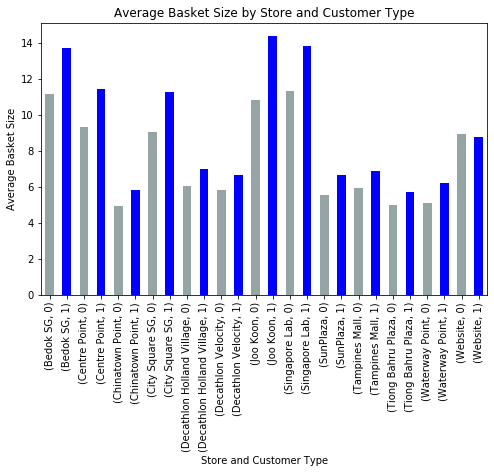

In [87]:
# Create a bar chart for basket size
plt.figure(figsize=(8, 5))
colors = ['#95a5a6', 'blue'] * int(np.ceil(len(basket_size) / 2))
basket_size.plot.bar(x='Store and Customer Type', y='Average Basket Size', rot=0,color=colors)
plt.xlabel('Store and Customer Type')
plt.ylabel('Average Basket Size')
plt.title('Average Basket Size by Store and Customer Type')
plt.tick_params(axis='x', labelrotation=90)

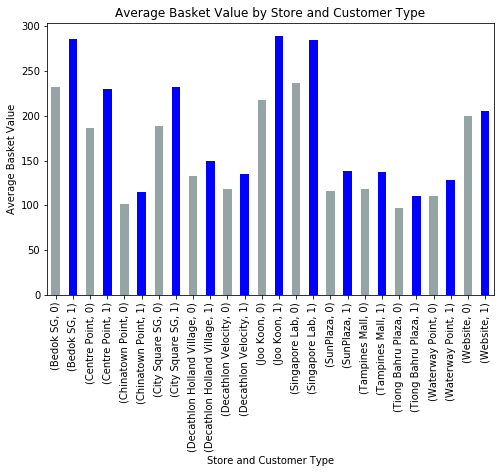

In [88]:
# Create a bar chart for basket value
plt.figure(figsize=(8, 5))
colors = ['#95a5a6', 'blue'] * int(np.ceil(len(basket_size) / 2))
basket_value.plot.bar(x='Store and Customer Type', y='Average Basket Value', rot=0,color=colors)
plt.xlabel('Store and Customer Type')
plt.ylabel('Average Basket Value')
plt.title('Average Basket Value by Store and Customer Type')
plt.tick_params(axis='x', labelrotation=90)

#### A-3: Conclusion

* For most channels, member's basket size are larger than non-memeber's. This is a good business sign as we always try to earn more revenue from memebers. However, for Website, memeber's basket size is fewer than non-member's. This may be a potential issue to further dig into.

* Website's basket value also have the same problem, member's basket value just slightly higher than non-member's.

* Without further domain knowledge, it's hard to conclude what cause this phenomenon. But based on this finding, I suggest Decathlon can further evaluate membership management strategy on website.

### B. Find the proportion (in %) of members who shopped at each channel exclusively as well as the different possible combinations of channels. <a id="qb"></a>

#### B-1: Channel Category

Based on the information on the Decathlon website (https://www.decathlon.sg/s/our-stores), the channels can be categorized like below:

1.**Experience Store**: Singapore Lab, Bedok SG, Joo Koon, City Square SG, Centre Point

2.**C&C stores**: Tampines Mall, Decathlon Velocity, Decathlon Holland Village, Waterway Point, SunPlaza, Tiong Bahru Plaza, Chinatown Point

3.**Online**: Website

In [89]:
df['but_name_business_unit'].value_counts()

Singapore Lab                1222678
Bedok SG                      907287
Joo Koon                      857280
City Square SG                815753
Centre Point                  617542
Website                       533818
Tampines Mall                 119129
Decathlon Velocity             98382
Decathlon Holland Village      85833
Waterway Point                 82399
SunPlaza                       70128
Tiong Bahru Plaza              44506
Chinatown Point                42016
Name: but_name_business_unit, dtype: int64

In [90]:
#only use member's data
df_member = df[df['is_member']==1]
# Create a new column to categorize the channels
df_member['store_category'] = df_member['but_name_business_unit'].map({
    'Singapore Lab': 'Experience Store',
    'Bedok SG': 'Experience Store',
    'Joo Koon': 'Experience Store',
    'City Square SG': 'Experience Store',
    'Centre Point': 'Experience Store',
    'Tampines Mall': 'C&C Store',
    'Decathlon Velocity': 'C&C Store',
    'Decathlon Holland Village': 'C&C Store',
    'Waterway Point': 'C&C Store',
    'SunPlaza': 'C&C Store',
    'Tiong Bahru Plaza': 'C&C Store',
    'Chinatown Point': 'C&C Store',
    'Website': 'Online'
})
#only include rows with f_qty_item and f_to_tax_in not equal to 0
df_member = df_member[(df_member['f_qty_item'] != 0) & (df_member['f_to_tax_in'] != 0)]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
# becuase there may be rows with same the_transaction_id, which means these rows refer to the same basket, so we need to first group by the_transaction_id.
channel_grouped = df_member.groupby(['the_transaction_id','ctm_customer_id', 'store_category']).agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'})
channel_grouped = channel_grouped.reset_index()

#### B-2: Pivot_table

In [92]:
# Create a pivot table to count the number of transactions per member and channel category
table = pd.pivot_table(channel_grouped, values='the_transaction_id', index='ctm_customer_id', columns='store_category', aggfunc='count', fill_value=0)
table

store_category,C&C Store,Experience Store,Online
ctm_customer_id,,,
000DFTLRKY,0,3,0
000FX6RHTM,0,2,0
000NZ1KH93,1,1,0
000R842PBV,0,0,1
0014SWGO7X,0,2,0
...,...,...,...
ZZZMIYQG58,0,1,0
ZZZPD2IMD6,0,0,1
ZZZS1QUNOD,0,2,0


In [93]:
# Create a new column that counts the number of channel a customer shops at
table['count_stores'] = np.count_nonzero(table, axis=1)

In [94]:
#add columns to indicate customers only shops at one channel
table['only_C&C Store'] = table.apply(lambda x: 1 if (x['count_stores'] == 1 and x['C&C Store'] != 0) else 0, axis=1)
table['only_Experience Store'] = table.apply(lambda x: 1 if (x['count_stores'] == 1 and x['Experience Store'] != 0) else 0, axis=1)
table['only_Online'] = table.apply(lambda x: 1 if (x['count_stores'] == 1 and x['Online'] != 0) else 0, axis=1)

In [95]:
#add columns to indicate customers only shops at two channels
table['C&C Store_Experience Store'] = table.apply(lambda x: 1 if (x['count_stores'] == 2 and x['C&C Store'] != 0 and x['Experience Store'] != 0) else 0, axis=1)
table['C&C Store_Online'] = table.apply(lambda x: 1 if (x['count_stores'] == 2 and x['C&C Store'] != 0 and x['Online'] != 0) else 0, axis=1)
table['Experience Store_Online'] = table.apply(lambda x: 1 if (x['count_stores'] == 2 and x['Experience Store'] != 0 and x['Online'] != 0) else 0, axis=1)

In [96]:
#add a column to indicate customers shops at all channels
table['all_types'] = table.apply(lambda x: 1 if (x['count_stores'] == 3 ) else 0, axis=1)

In [97]:
table

store_category,C&C Store,Experience Store,Online,count_stores,only_C&C Store,only_Experience Store,only_Online,C&C Store_Experience Store,C&C Store_Online,Experience Store_Online,all_types
ctm_customer_id,,,,,,,,,,,
000DFTLRKY,0,3,0,1,0,1,0,0,0,0,0
000FX6RHTM,0,2,0,1,0,1,0,0,0,0,0
000NZ1KH93,1,1,0,2,0,0,0,1,0,0,0
000R842PBV,0,0,1,1,0,0,1,0,0,0,0
0014SWGO7X,0,2,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
ZZZMIYQG58,0,1,0,1,0,1,0,0,0,0,0
ZZZPD2IMD6,0,0,1,1,0,0,1,0,0,0,0
ZZZS1QUNOD,0,2,0,1,0,1,0,0,0,0,0


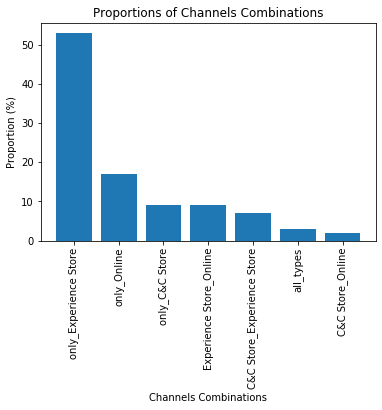

only_Experience Store is 53%
only_Online is 17%
only_C&C Store is 9%
Experience Store_Online is 9%
C&C Store_Experience Store is 7%
all_types is 3%
C&C Store_Online is 2%


In [98]:
# Initialize lists to store the variable names and proportions
names = []
proportions = []

# Calculate the proportions and add them to the lists
for i in range(4,11):
    proportion = round(table[table.iloc[:,i]==1].shape[0]/table.shape[0]*100)
    name = table.columns[i]
    names.append(name)
    proportions.append(proportion)

# Sort the names and proportions in descending order by proportion
sorted_names, sorted_proportions = zip(*sorted(zip(names, proportions), key=lambda x: x[1], reverse=True))

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(sorted_names, sorted_proportions)
ax.set_xlabel('Channels Combinations')
ax.set_ylabel('Proportion (%)')
ax.set_title('Proportions of Channels Combinations')
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# Print the sorted names and proportions
for name, proportion in zip(sorted_names, sorted_proportions):
    print(f'{name} is {proportion}%')

#### B-3: Conclusion

* Over 50% of members only shops at Experience Store.

* Most members prefer to use only one type of channel.

* C&C Store and Online together has the minimal proportion. This may because the customers who choose to buy online and wait for delivery may have less willings to leave home and pick up products by themselves.

### C.If there is any timing of the day that is most popular for purchases in stores? Please state the consideration(s) you have made. <a id="qc"></a>

In [99]:
# becuase there may be rows with same the_transaction_id, which means these rows refer to the same basket, so we need to first group by the_transaction_id.
timing_grouped = df.groupby(['the_transaction_id','the_date_transaction','the_to_type']).agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'})
timing_grouped = timing_grouped.reset_index()

In [100]:
#To analyze the popular timing in a day for this question, we need to add a column to capture hour
timing_grouped['transaction_hour'] = timing_grouped['the_date_transaction'].dt.hour
# Create a new column called 'day_type' to indicate whether the transaction occurred on a weekday or a weekend
timing_grouped['day_type'] = timing_grouped['the_date_transaction'].apply(lambda x: 'weekday' if x.weekday() < 5 else 'weekend')

In [101]:
#the question focus on purchase in store, so I would exclude online transaction
df_offline = timing_grouped[timing_grouped['the_to_type']=='offline']

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


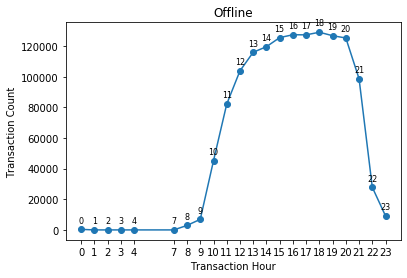

In [102]:
# Aggregate the transaction counts by hour
transactions_by_hour = df_offline.groupby('transaction_hour')['the_transaction_id'].count()

# Create a line chart of the transactions by hour
plt.plot(transactions_by_hour.index, transactions_by_hour.values, marker='o')

# Set the x-axis label and title
plt.xlabel('Transaction Hour')
plt.ylabel('Transaction Count')
plt.title('Offline')

# Set the x-axis tick marks and labels
plt.xticks(transactions_by_hour.index)

# Add text annotations for each transaction count value
for x, y in zip(transactions_by_hour.index, transactions_by_hour.values):
    plt.text(x, y+3000, x, ha='center', va='bottom', fontsize=8)
    
# Display the plot
plt.show()


#### C-1: Offline

* The transaction in offline store starts to grow after 9am and starts to drop after 8pm.
* The peak hour is around 3pm-8pm.
* There are no offline transactions made in 5 and 6 am.

Customer behavior may be different on weekdays and weekends, so now we try to seperate transactions by weekday/weekend.

In [103]:
#find offline transaction on weekday
df_offline_weekday = df_offline[df_offline['day_type']=='weekday']

In [104]:
#find offline transaction on weekend
df_offline_weekend = df_offline[df_offline['day_type']=='weekend']

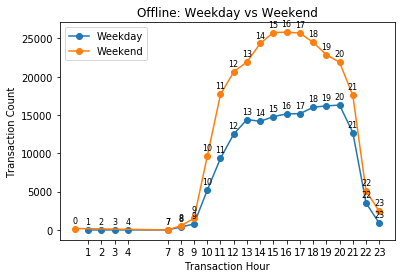

In [105]:
# Aggregate the transaction counts by hour and take average
transactions_by_hour_weekday = df_offline_weekday.groupby('transaction_hour')['the_transaction_id'].count()/5
transactions_by_hour_weekend = df_offline_weekend.groupby('transaction_hour')['the_transaction_id'].count()/2

# Create a line chart of the transactions by hour
plt.plot(transactions_by_hour_weekday.index, transactions_by_hour_weekday.values, marker='o', label='Weekday')

plt.plot(transactions_by_hour_weekend.index, transactions_by_hour_weekend.values, marker='o', label='Weekend')

# Set the x-axis label and title
plt.xlabel('Transaction Hour')
plt.ylabel('Transaction Count')
plt.title('Offline: Weekday vs Weekend')

# Set the x-axis tick marks and labels
plt.xticks(transactions_by_hour_weekday.index)

# Add text annotations for each transaction count value
for x, y in zip(transactions_by_hour_weekday.index, transactions_by_hour_weekday.values):
    plt.text(x, y+500, x, ha='center', va='bottom', fontsize=8)
# Add text annotations for each transaction count value
for x, y in zip(transactions_by_hour_weekend.index, transactions_by_hour_weekend.values):
    plt.text(x, y+500, x, ha='center', va='bottom', fontsize=8)

plt.legend()
# Display the plot
plt.show()


#### C-2: Weekday vs Weekend

* Average transcation on weekend is higher than on weekday.
* There is a high peak from 3pm to 5pm on weekend while the trend is consistent from 1pm to 8pm on weekday.

Now we know 11am to 9pm is the most popular timing of a day, so let's find out do popular products change throughout these time.

In [106]:
# previously we didn't include product_type in our groupby function, so now we need to create a new groupby function with product_type
product_type_grouped = df.groupby(['the_transaction_id','the_date_transaction','product_type','the_to_type']).agg({'f_qty_item': 'sum', 'f_to_tax_in': 'sum'})
product_type_grouped = product_type_grouped.reset_index()

In [107]:
#To analyze the popular timing in a day for this question, we need to add a column to capture hour
product_type_grouped['transaction_hour'] = product_type_grouped['the_date_transaction'].dt.hour
# Create a new column called 'day_type' to indicate whether the transaction occurred on a weekday or a weekend
product_type_grouped['day_type'] = product_type_grouped['the_date_transaction'].apply(lambda x: 'weekday' if x.weekday() < 5 else 'weekend')

In [108]:
#choose offline transaction
df_offline2 = product_type_grouped[product_type_grouped['the_to_type']=='offline']
# Group the transactions by hour and product type and sum up f_qty_item
hourly_products = df_offline2.groupby(['transaction_hour', 'product_type'])['f_qty_item'].sum().reset_index()
# Sort by transaction count
hourly_products = hourly_products.sort_values('f_qty_item', ascending=False)

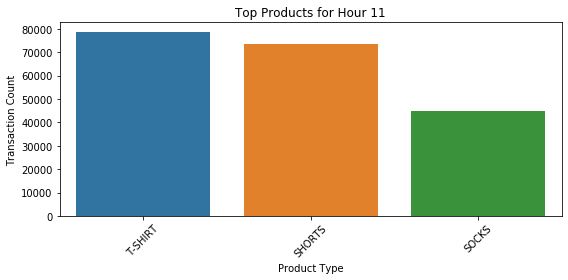

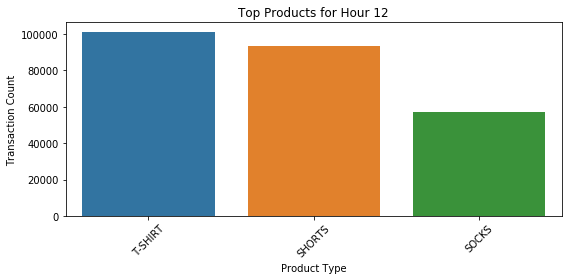

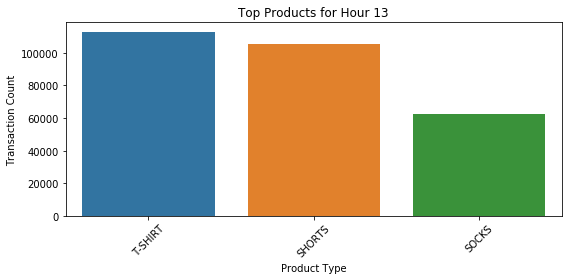

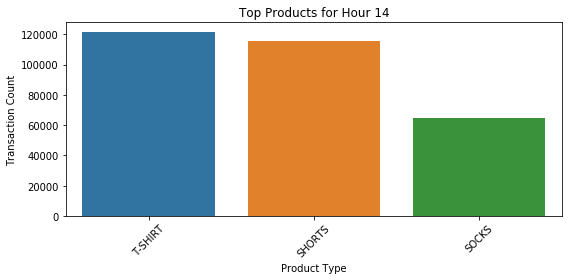

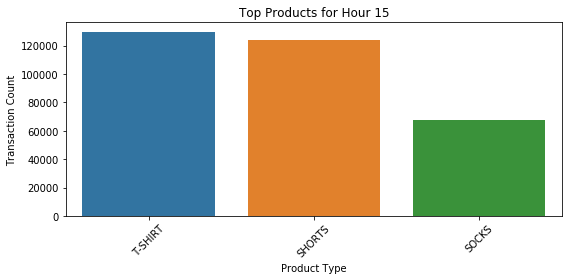

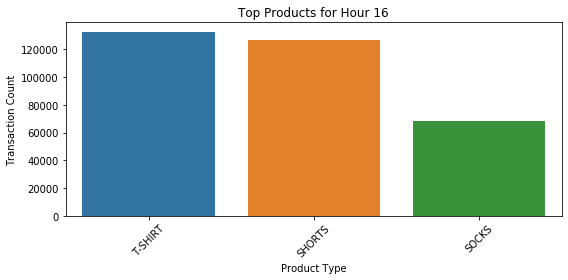

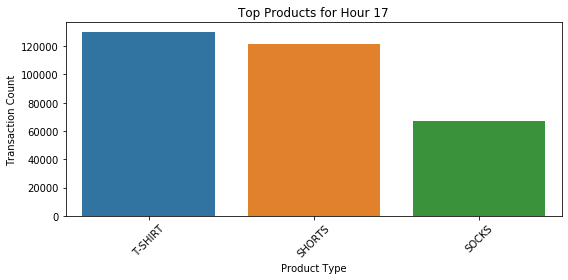

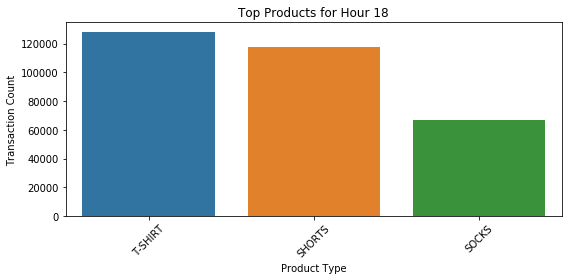

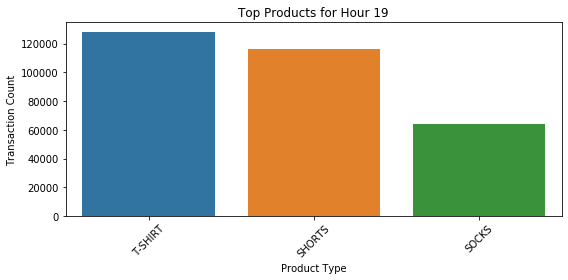

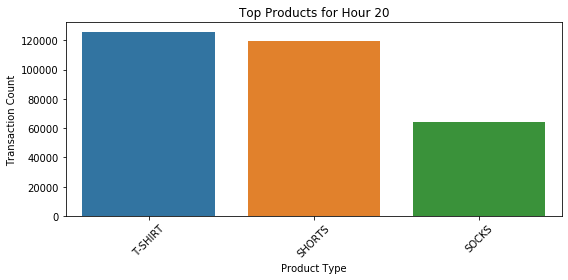

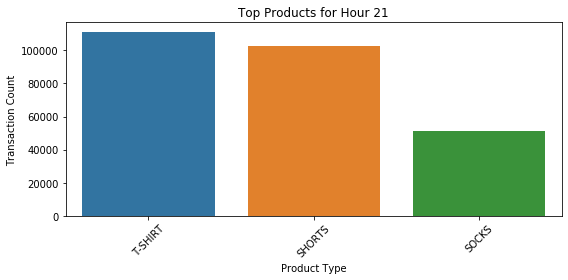

In [109]:
import seaborn as sns
# Loop through each hour of the popular timing and create a plot for the top 3 products
for hour in range(11,22):
    # Filter the data for the current hour
    hourly_data = hourly_products[hourly_products['transaction_hour'] == hour]
    
    # Get the top 3 products for the current hour
    top_products = hourly_data.groupby('product_type')['f_qty_item'].sum().nlargest(3).index.tolist()
    
    # Filter the data to only include the top products
    hourly_data = hourly_data[hourly_data['product_type'].isin(top_products)]
    
    # Create a bar plot for the current hour
    plt.figure(figsize=(8, 4))
    sns.barplot(x='product_type', y='f_qty_item', data=hourly_data)
    plt.title(f'Top Products for Hour {hour}')
    plt.xlabel('Product Type')
    plt.ylabel('Transaction Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()


#### C-3: Popular product types within the peak time

* Popular product tyeps are all T-shirt, Shorts and Socks throughout the peak time

Now we know the popular timing for store, how about online?

In [110]:
df_online = timing_grouped[timing_grouped['the_to_type']=='online']

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


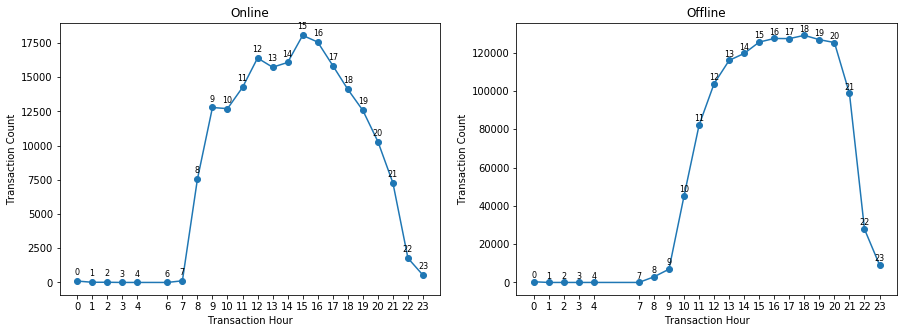

In [111]:
# Create a figure with two subplots, sharing the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))

# Aggregate the transaction counts by hour
transactions_by_hour_online = df_online.groupby('transaction_hour')['the_transaction_id'].count()
transactions_by_hour_offline = df_offline.groupby('transaction_hour')['the_transaction_id'].count()


# Create a line chart of the transactions by hour
ax1.plot(transactions_by_hour_online.index, transactions_by_hour_online.values, marker='o',label='online')
ax2.plot(transactions_by_hour_offline.index, transactions_by_hour_offline.values, marker='o',label='offline')


# Set the x-axis label and title
ax1.set_xlabel('Transaction Hour')
ax1.set_ylabel('Transaction Count')
ax1.set_title('Online')

# Set the x-axis label and title
ax2.set_xlabel('Transaction Hour')
ax2.set_ylabel('Transaction Count')
ax2.set_title('Offline')

# Set the x-axis tick marks and labels
ax1.set_xticks(transactions_by_hour_online.index)
ax2.set_xticks(transactions_by_hour_offline.index)

# Add text annotations for each transaction count value
for x, y in zip(transactions_by_hour_online.index, transactions_by_hour_online.values):
    ax1.text(x, y+300, x, ha='center', va='bottom', fontsize=8)
for x, y in zip(transactions_by_hour_offline.index, transactions_by_hour_offline.values):
    ax2.text(x, y+1000, x, ha='center', va='bottom', fontsize=8)


# Display the plot
plt.show()


#### C-4: Online vs Offline

* Comparing to Offline, Online has clearer peak time (12pm-5pm).
* Online transaction starts to grow after 7am while offline transaction starts to grow after 9am, since online transaction is not limited to opening time of store.